<a href="https://colab.research.google.com/github/pepperamy/tenK_phase2/blob/main/Copy_of_10k_featureselection_all%20model%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle
import re
from matplotlib import pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mstats
import math

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import KFold,StratifiedKFold

In [3]:
from keras import regularizers

In [4]:
from keras import backend as K

In [5]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

In [6]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Reshape, Conv1D, MaxPooling1D,\
Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional,\
ZeroPadding2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import optimizers
from keras import metrics
from keras import models
from keras import layers

In [7]:
from sklearn.utils import class_weight

In [8]:
from sklearn import utils

In [9]:
import random

In [10]:
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
#from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# data prepare

In [11]:
df = pd.read_csv('data_performance_words_win1_comb_20210301.csv')

In [12]:
df.shape

(53635, 212)

In [13]:
sum(df.label)

487.0

In [14]:
df.head()

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down
0,20.0,1995.0,1996.0,0.633505,1.0,0.0,3,0.063117,-0.072425,-0.067847,0.661974,-0.147079,0.198730,1,0.974056,1.624273,0.206066,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528,NaN,NaN,NaN,NaN,NaN,NaN,-0.000071,0.000000,0.095238,0.004950,0.047619,0.761905,-0.002775,0.002801,0.190476,0.000000,...,0.047619,0.571429,-0.004527,0.016180,0.428571,0.029638,0.285714,0.190476,-0.000009,0.002644,0.190476,0.000000,0.190476,0.523810,-0.002433,0.002488,0.333333,0.019737,0.000000,0.571429,0.052570,0.095238,0.142857,0.193277,0.047619,0.058512,0.353070,0.338308,0.238095,0.292404,0.100189,0.145658,0.395804,0.355975,0.060777,0.303224,0.190476,0.248916,0.190476,0.193121
1,20.0,1996.0,1997.0,0.803827,1.0,0.0,3,0.066126,-0.018252,-0.059281,0.620435,-0.066028,0.034753,1,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432,0.633505,0.633505,0.633505,1.268856,1.268856,1.268856,-0.000034,0.000000,0.066667,0.028571,0.000000,0.866667,0.003234,0.000000,0.133333,0.000000,...,0.133333,0.733333,-0.003780,0.018289,0.333333,0.000000,0.200000,0.400000,0.000668,0.007947,0.200000,0.000000,0.200000,0.533333,-0.001054,0.013954,0.066667,0.000000,0.066667,0.800000,0.028571,0.066667,0.200000,0.133333,0.161905,0.066667,0.161905,0.357243,0.200000,0.219242,0.123810,0.134598,0.333333,0.144428,0.133333,0.075494,0.133333,0.070482,0.200000,0.207947
2,20.0,1997.0,1998.0,0.462705,1.0,0.0,3,0.095900,0.066711,0.013223,0.656729,-0.030720,0.019574,1,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269,0.718666,0.718666,0.803827,0.643838,0.643838,0.575627,0.002823,0.005714,0.066667,0.007841,0.133333,0.466667,-0.001499,0.004000,0.133333,0.004315,...,0.066667,0.333333,0.000062,0.028035,0.266667,0.021889,0.266667,0.133333,-0.003310,0.001504,0.266667,0.002960,0.000000,0.400000,-0.000069,0.011111,0.066667,0.004688,0.066667,0.533333,0.141174,0.072381,0.137649,0.137333,0.074024,0.139048,0.149893,0.299598,0.070786,0.271178,0.154181,0.144762,0.484144,0.236060,0.074921,0.277778,0.076624,0.202532,0.002960,0.268170
3,20.0,1998.0,1999.0,0.701689,1.0,0.0,3,0.054997,0.026323,-0.009875,0.676757,0.011434,0.002424,1,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057,0.633346,0.633346,0.462705,1.107909,1.107909,1.516495,0.000590,0.006755,0.045455,0.000000,0.136364,0.545455,-0.000112,0.005460,0.090909,0.000000,...,0.090909,0.590909,0.001965,0.034894,0.090909,0.019415,0.136364,0.500000,0.000347,0.003575,0.000000,0.008179,0.045455,0.681818,-0.000126,0.003620,0.090909,0.000000,0.090909,0.545455,0.136364,0.052210,0.045455,0.096370,0.048976,0.140434,0.093257,0.110468,0.045455,0.050488,0.187374,0.063963,0.195518,0.159758,0.101197,0.055574,0.103194,0.144520,0.053633,0.003575
4,20.0,1999.0,2000.0,0.823023,1.0,0.0,3,-0.024892,-0.024929,0.041267,0.705573,-0.001713,-0.014429,1,1.093648,1.560280,-0.015406,0.942174,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184,0.650432,0.656074,0.701689,1.265350,1.254468,1.172917,-0.000791,0.002083,0.176471,0.000000,0.000000,0.764706,-0.000278,0.003717,0.117647,0.000000,...,0.176471,0.647059,-0.001826,0.011784,0.117647,0.054348,0.058824,0.

In [15]:
df_fl = df[(df.y2 <= 2012) & (df.y2 >= 1995 ) ]

In [16]:
df_fl.label.value_counts()

0.0    53148
1.0      487
Name: label, dtype: int64

In [17]:
df_fl.shape

(53635, 212)

In [18]:
selected_new = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
         'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious'][::-1]

v_perf = ['aqi',
 'asset_turnover',
 'depi',
 'gmi',
 #'ig',
 'opm',
 'rg',
 'sg',
 'sgee',
 'ch_rec',
 'ch_inv',
 'soft_asset',
 'ch_cs',
 'ch_roa',
 'issue']

v_1 = ['s1']
v_2 = ['pastavg3','cr3']

In [19]:
# selected_comb = []
# for s in selected_new:
#   selected_comb.append(s+'_up')
#   selected_comb.append(s+'_down')

In [20]:
selected_new_all = []
temp = []
for s in selected_new:
    wrd = s.split('_')[0]
    if wrd not in temp:
        #print(s,'\n',temp)
        #selected_new_all.append(wrd+'_3_avg')
        selected_new_all.append(wrd+'_3_p')
        selected_new_all.append(wrd+'_3_n')
        #selected_new_all.append(wrd+'_3_u')
        selected_new_all.append(wrd+'_3_new')
        selected_new_all.append(wrd+'_3_dis')
        temp.append(wrd)
    else: 
        pass

In [ ]:
selected_new_all

In [22]:
selected_new_all_sorted = []
selected_new_all_p = []
selected_new_all_n = []
selected_new_all_new = []
selected_new_all_dis = []
for s in selected_new_all:
  if 'new' in s.split('_'):
    selected_new_all_new.append(s)
  elif 'p' in s.split('_'):
    selected_new_all_p.append(s)
  elif 'n' in s.split('_'):
    selected_new_all_n.append(s)
  elif 'dis' in s.split('_'):
    selected_new_all_dis.append(s)

for i, w in enumerate(selected_new_all_p):
  selected_new_all_sorted.append(selected_new_all_p[i])
  selected_new_all_sorted.append(selected_new_all_new[i])
  selected_new_all_sorted.append(selected_new_all_n[i])
  
  selected_new_all_sorted.append(selected_new_all_dis[i])  


In [ ]:
selected_new_all_sorted

# SVM

In [49]:
def svm( data, vs, label = 'label'):
    
    columns_fl = vs[1] #+ [ 'sic_class_x']
    
    data_target = data.loc[:,columns_fl + [label]]
    
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []

    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    print(data_target.label.value_counts())
     
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        svm = LinearSVC(class_weight = "balanced")
        svm.fit(train_x, train_y )
        pickle.dump(svm, open('svm_'+str(vs[0])+ '_'+str(c), 'wb'))
        

        pred = svm.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = svm.decision_function(test_x)
        auc_score = roc_auc_score(test_y, decision_values)
        print(auc_score)
        auc_list.append(auc_score)
        
        fpr, tpr, thresholds = roc_curve(test_y, decision_values)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
#         mean_tpr = np.mean(tprs, axis=0)
#         mean_auc = auc(mean_fpr, mean_tpr)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
    
#     coef_s = 0
#     for i in coef:
#         coef_s += abs(i)
#     coef_avg = coef_s / len(coef)
#     coef_top = pd.DataFrame(coef_avg, index = columns_fl,columns = ['importance'])
#     coef_top = coef_top.sort_values('importance',ascending=False)
#     print(coef_top.iloc[0:10,:])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [50]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf +v_1 +v_2 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
#    print(fl)
    svm_model = svm( df_fl, fl,label = 'label')
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

0.0    53148
1.0      487
Name: label, dtype: int64
iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  2885.0 

0.6642768045186531
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  3303.0 

0.6832457955329195
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  3269.0 

0.6809145386776425
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  3063.0 

0.6925454383735548
avg_AUC :  0.6802456442756925
avg_AUC_2 :  0.6805165528746344
frauds_prec :  0.017430809883589825
fradus_recall :  0.44775436932664947


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6802456442756925
0.0    45204
1.0      407
Name: label, dtype: int64
iterate_num:  1 
 sum of test_y: 102.0
sum of pred:  1944.0 

0.6847146964263097
iterate_num:  2 
 sum of test_y: 102.0
sum of pred:  1892.0 

0.7080685207451708
iterate_num:  3 
 sum of test_y: 102.0
sum of pred:  1899.0 

0.6666718718281046
iterate_num:  4 
 sum of test_y: 

# LR


In [53]:
def lg( data,vs, label = 'label'):
    
    
    columns_fl = vs[1]# + [ 'sic_class_x']
    data_target = data.loc[:,columns_fl + [label]]
    
        
#     train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,test_size=0.2, random_state=19, 
#                                                                         stratify = data_y) 

    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        lg = LogisticRegression(class_weight = 'balanced')
        lg.fit(train_x, train_y )
        #pickle.dump(lg, open('lg_'+str(vs[0])+ '_'+str(c), 'wb'))

        pred = lg.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = lg.predict_proba(test_x)
        auc_score = roc_auc_score(test_y, decision_values[:,1])
        print(auc_score)
        auc_list.append(auc_score)
        fpr, tpr, thresholds = roc_curve(test_y, decision_values[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
        #print('AUC',auc_score)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [54]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf+v_1+v_2+selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    lg_model = lg( df_fl, fl,label = 'label')
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

iterate_num:  1 
 sum of test_y: 122.0
sum of pred:  5340.0 

0.6703390593788826
iterate_num:  2 
 sum of test_y: 122.0
sum of pred:  5158.0 

0.6768781762526418
iterate_num:  3 
 sum of test_y: 122.0
sum of pred:  5217.0 

0.6674303861656963
iterate_num:  4 
 sum of test_y: 121.0
sum of pred:  5297.0 

0.6779882405408381
avg_AUC :  0.6731589655845147
avg_AUC_2 :  0.6733243216612679
frauds_prec :  0.014709944743580906
fradus_recall :  0.6345007451564829


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.6731589655845147
iterate_num:  1 
 sum of test_y: 102.0
sum of pred:  4623.0 

0.7197523731198523
iterate_num:  2 
 sum of test_y: 102.0
sum of pred:  4405.0 

0.6156925207035296
iterate_num:  3 
 sum of test_y: 102.0
sum of pred:  4181.0 

0.6563994857300499
iterate_num:  4 
 sum of test_y: 101.0
sum of pred:  4509.0 

0.7042152582659381
avg_AUC :  0.6740149094548424
avg_AUC_2 :  0.674124030050

# NN

In [24]:
def model_M1(n1,n2):
    model_m1 = Sequential(name = 'M1')
    model_m1.add(BatchNormalization())
    model_m1.add(layers.Dense(n1,name = 'layer_1',activation='relu'))
    model_m1.add(layers.Dropout(0.3))
    #model_m1.add(layers.Dense(64,name = 'layer_2'))
    model_m1.add(layers.Dense(n2,name = 'layer_2',activation='relu'))
    model_m1.add(layers.Dense(1,activation='sigmoid'))
    #model_m1.summary()
    return model_m1

In [25]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [26]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [30]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights)) 
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [31]:
def cross_val(n1, n2, data,label,columns_fl,model_name):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_1 = data[columns_fl + [label]]
    data_1 = data_1.dropna()
    data_target = data_1.reset_index(drop = True)
    
    predicted_res =[]
    
    
    
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_data = data_target.loc[train_index,columns_fl]
        train_label = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl].to_numpy()
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
        train_x, val_x, train_y, val_y = train_test_split(train_data.to_numpy(), train_label.to_numpy(),test_size=0.2, \
                                                            random_state=42, stratify = train_label)
        print('train_x_shape',train_x.shape)
        model = model_M1(n1,n2)
        mod_res = fit_model(model, train_x, train_y, val_x, val_y, test_x, test_y, model_name+'_'+str(c)+'_NN_model')
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
#         print(type(mod_res[-1]))
#         print(len(mod_res[-1]))
#         print(mod_res[-1])
        temp_pred_res = [mod_res[-1],test_index]
        #print(temp_pred_res)
        predicted_res.append(temp_pred_res)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.mean(auc_list),mean_tpr, predicted_res

In [33]:
label = 'label'
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf +v_1 +v_2 +selected_new_all}
#
mean_tpr_dict_nn = dict()
pred_res_nn = dict()
for fl in vs_fl.items():
    print(fl[1])
    n1 = len(fl[1])*2
    n2 = len(fl[1])
    #M1 = model_M1(n1,n2)
    NN = cross_val(n1, n2, df_fl, label, fl[1], fl[0])
    print(fl)
    print(NN[0])
    mean_tpr_dict_nn[fl[0]] = NN[1]
    pred_res_nn[fl[0]] = NN[2]

['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue']
iterate_num:  1 
 sum of test_y: 122.0
train_x_shape (32180, 14)
Epoch 1/30
63/63 [==============================] - 3s 24ms/step - loss: 0.7030 - accuracy: 0.5836 - my_auc: 0.5588 - val_loss: 0.6930 - val_accuracy: 0.4172 - val_my_auc: 0.5044
 epoch:0 auc: 0.5028
Epoch 2/30
63/63 [==============================] - 0s 7ms/step - loss: 0.6649 - accuracy: 0.5973 - my_auc: 0.6450 - val_loss: 0.6821 - val_accuracy: 0.4778 - val_my_auc: 0.5864
 epoch:1 auc: 0.5858
Epoch 3/30
63/63 [==============================] - 0s 7ms/step - loss: 0.6703 - accuracy: 0.6026 - my_auc: 0.6424 - val_loss: 0.6709 - val_accuracy: 0.5717 - val_my_auc: 0.6321
 epoch:2 auc: 0.6329
Epoch 4/30
63/63 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.6024 - my_auc: 0.6239 - val_loss: 0.6621 - val_accuracy: 0.6181 - val_my_auc: 0.6494
 epoch:3 auc: 0.6509
Epoch 5/



---



# LSTM+CNN+TCN



In [24]:
# def model_cnn(w, num_wrds, num_depth):
#   model = None
#   input_wds = Input(shape=(w, num_wrds, 1),dtype='float32', name='input_words')

#   cov = Conv2D(4, (2,2), activation='relu')(input_wds)
#   maxpool = MaxPooling2D((1,1))(cov)
#   #reshp = Reshape((1,64))(maxpool)
#   #flt = Flatten()(maxpool)
#   model = Model(inputs=input_wds, outputs= maxpool)
#   model._name = 'cnn'          
#   model.summary()
#   return model



In [25]:
# def model_lstm(n1, n2, n3, w, num_wrds, num_perf, num_depth):
#     model = None
    
#     input_perf = Input(shape=(1,num_perf),dtype='float32', name='input_financial')
#     input_wds = Input(shape=(w,num_wrds),dtype='float32', name='input_words')

#     cnnmodel = model_cnn(w, num_wrds, num_depth)
#     cnn_wrds = cnnmodel(input_wds)

#     reshp_perf = Reshape((1,num_perf))(input_perf)

#     concate = Concatenate(axis=-1)([cnn_wrds,input_perf])

#     #nor = BatchNormalization()(concate)
#     drop1 = Dropout(0.3)(concate)
#     #nor = BatchNormalization()(drop1)
#     # LSTM_w_1 = Bidirectional(LSTM(81,recurrent_dropout = 0.2, name = 'layer_lstm_1',\
#     #                   return_sequences=True, \
#     #                #kernel_regularizer=regularizers.l2(0.01),\
#     #                #bias_regularizer=regularizers.l2(0.01),
#     #               activity_regularizer=regularizers.l2(0.01)))(drop1)
#     LSTM_w_2 = LSTM(81,recurrent_dropout = 0.2, name = 'layer_lstm_2', \
#                 return_sequences=False )(drop1)        
#     #nor = BatchNormalization()(LSTM_w_2)
#     dense1 = Dense(81, activation='relu', name='dense1')(LSTM_w_2)
#     dense2 = Dense(n3, activation='relu', name='dense2')(dense1)
#     nor = BatchNormalization()(dense2)
#     drop2 = Dropout(0.3)(nor)
    
#     preds = Dense(1, activation='sigmoid', name='output')(drop2)
#     model = Model(inputs=[input_perf, input_wds], outputs=preds)
#     model._name = "lstm"
#     model.summary()
    
#     return model

In [26]:
#LR
# def model_cnn_lstm(n1, n2, n3, T, perf, words, channel, filters = 24):
#     model = None
    
#     input_perf = Input(shape=(T,perf), \
#                       dtype='float32', name='input_perf')
    
#     input_words = Input(shape=(T, words, channel), \
#                       dtype='float32', name='input_words') 
    
#     word_norm = BatchNormalization()(input_words)
    
    
#     conv = Conv2D(filters = filters,\
#                   kernel_size = 1,\
#                   use_bias = False,\
#                   activation = None)(word_norm)  # Shape None x T x words x filters
#     print("conv shape:", K.int_shape(conv))
#     conv = BatchNormalization()(conv)
#     conv = Activation("relu") (conv)
    
#     pool = MaxPooling2D(pool_size=(1, words), \
#                         strides=(1,1))(conv) # None x T x filters
#     pool = Reshape((T, filters))(conv)
#     print("pool shape:", K.int_shape(pool))
    
#     #drop = Dropout(0.3)(input_all)
#     # Now concatenate
#     perf_norm = BatchNormalization()(input_perf)
#     all_input = Concatenate(axis = -1)([perf_norm, pool])
#     #nor = BatchNormalization()(all_input)
    
#     LSTM_w_1 = Bidirectional(LSTM(n1, dropout= 0.3, recurrent_dropout = 0.3,\
#                     name = 'layer_lstm_1', return_sequences=True))(all_input)
#     LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
#                    name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
#     dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
#     drop = Dropout(0.3)(dense)
    
#     preds = Dense(1, activation='sigmoid', name='output')(drop)
#     model = Model(inputs=[input_perf, input_words], outputs=preds)
#     model._name = "model_cnnlstm"
#     model.summary()
    
#     return model

In [34]:
def model_cnn_lstm_1(n1,n2,n3,T, perf, words, types ,filters = 32): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool_1 = MaxPooling2D(pool_size= (1,17), \
                        strides=1)(conv)
    pool_1 = Reshape((T, filters))(pool_1)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool_2 = MaxPooling2D(pool_size= (1,14), \
                        strides=1)(conv)
    pool_2 = Reshape((T, filters))(pool_2)


    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool_3 = MaxPooling2D(pool_size= (1,11), \
                        strides=1)(conv)
    pool_3 = Reshape((T, filters))(pool_3)
    
    # conv = Conv2D(filters = filters,\
    #               kernel_size = (1,4),\
    #               activation = 'relu')(conv)  # Shape None x T x words x filters
    # print("conv shape 4:", K.int_shape(conv))
    # conv = BatchNormalization()(conv)
    # conv = Activation("relu") (conv)
    # pool_4 = MaxPooling2D(pool_size= (1,8), \
    #                     strides=1)(conv)
    # pool_4 = Reshape((T, filters))(pool_4)
    
    # pool = MaxPooling2D(pool_size= (1,8), \
    #                     strides=1)(conv) # None x T x filters
    
    # print("pool_init shape:", K.int_shape(pool))
    # pool = Reshape((T, filters))(pool)
    # print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool_3, pool_2, pool_1 ])
    nor = BatchNormalization()(all_input)
    #drop = Dropout(0.3)(nor)
    
    LSTM_w_1 =Bidirectional(LSTM(120,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(120, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm_1"
    model.summary()
    
    return model

In [35]:
def model_cnn_lstm_2(n1,n2,n3,T, perf, words, types ,filters = 32): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)


    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(conv)  # Shape None x T x words x filters
    print("conv shape 4:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size= (1,8), \
                        strides=1)(conv) # None x T x filters
    
    print("pool_init shape:", K.int_shape(pool))
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool ])
    nor = BatchNormalization()(all_input)
    #drop = Dropout(0.3)(nor)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(n2, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm_2"
    model.summary()
    
    return model

In [36]:
def model_cnn_lstm_3(n1,n2,n3,T, perf, words, types ,filters = 32): #channel,
    model = None
    filters = 32
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,types), \
                      dtype='float32', name='input_words')
    

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(input_words)  # Shape None x T x words x filters
    print("conv shape 1:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool = MaxPooling2D(pool_size= (1,4), \
                        strides=1)(conv)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(pool)  # Shape None x T x words x filters
    print("conv shape 2:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    pool = MaxPooling2D(pool_size= (1,4), \
                        strides=1)(conv)

    conv = Conv2D(filters = filters,\
                  kernel_size = (1,4),\
                  activation = 'relu')(pool)  # Shape None x T x words x filters
    print("conv shape 3:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    # conv = Conv2D(filters = filters,\
    #               kernel_size = (1,4),\
    #               activation = 'relu')(conv)  # Shape None x T x words x filters
    # print("conv shape 4:", K.int_shape(conv))
    # conv = BatchNormalization()(conv)
    # conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size= (1,5), \
                        strides=1)(conv) # None x T x filters
    
    print("pool_init shape:", K.int_shape(pool))
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    
    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool ])
    nor = BatchNormalization()(all_input)
    #drop = Dropout(0.3)(nor)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    kernel_regularizer = regularizers.l2(0.01),
                    activity_regularizer = regularizers.l2(0.01),
                    bias_regularizer = regularizers.l2(0.01)
                    ))(nor)
    LSTM_w_2 = LSTM(n2, recurrent_dropout = 0.2, 
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(32, activation='relu', name='dense')(LSTM_w_2)
    nor = BatchNormalization()(dense)
    drop = Dropout(0.3)(nor)
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_cnnlstm_3"
    model.summary()
    
    return model

In [37]:
def model_tcn(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    #all_rsp = Reshape((filters+15,))(all_input)
    #nor = BatchNormalization()(all_input)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    # kernel_regularizer = regularizers.l2(0.01),
                    # activity_regularizer = regularizers.l2(0.01),
                    # bias_regularizer = regularizers.l2(0.01)
                    ))(all_input)
    LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
    dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
    drop = Dropout(0.3)(dense)
    
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model
    

In [38]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [39]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))


In [40]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    print('in fit, val_y: ', sum(y_val), 'test_y',sum(y_test), 'train_y',sum(y_train))

    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    #print('in fit val weights', val_sample_weights.shape)
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])

    history = model_df.fit(x_train,
                y_train,
                epochs=15,
                batch_size=128,
                verbose =verbose,
                #callbacks=[auc_eval],\
                callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val, y_val, val_sample_weights)) 
    
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
    print([ round(h,4) for h in history.history['val_loss']])    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [41]:
def cross_val(data, label, perf_cols, words_cols, name, w, filters = 24):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf, X_word, Y = shift_data(df_fl, w, \
                    perf_cols, \
                    words_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1]+ filters + 16
        
        model = model_tcn(l1,l1,32,\
                    X_perf.shape[1],\
                    X_perf.shape[2],
                    X_word.shape[2], \
                    X_word.shape[3], \
                    filters = 24)
    
        #model = model_lstm(n1,n2,n,w)
        train_x, train_val = train_test_split(train_index,test_size=0.2, \
                              random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_x]
        train_word_data = X_word[train_x]
        train_perf_val = X_perf[train_val]
        train_word_val = X_word[train_val]
        train_label = Y[train_x]
        val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        train_data = [train_perf_data, train_word_data]
        val_data = [train_perf_val,train_word_val]
        test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_data, train_label, val_data, val_label, test_x, test_y,\
                  name+'_'+str(c)+'_lstm_model')
        history = mod_res[0]
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.average(auc_list),mean_tpr,predicted_res

In [ ]:
#a = np.arange(16).reshape((2,8#))

In [ ]:
#a

In [ ]:
#a.reshape((2,8), order = '')

In [ ]:
#a.reshape((2,4,2), order = 'C')

In [51]:
def shift_data(data, step, perf_cols, words_cols, label):
    A = []
    
    cols = perf_cols + words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # CNN_LSTM must be None x T x words x 4
    A_words = A[:, :, len(perf_cols):]
    #convert the shape to [[_p,_new][_dis,_n]]
    A_words = A_words.reshape((len(A), step, int(len(words_cols)/2), 2), order = 'C')
    
    print(A_perf.shape, A_words.shape, Y.sum())
    return A_perf, A_words, Y


In [52]:
#shift_perf,shit_wrd, _y = shift_data(df_fl, 3, v_perf + v_1+ v_2, selected_new_all_sorted, label='label')

In [53]:
#shit_wrd[2]

In [54]:
# for k , fr in df_fl.groupby("cik"):
#   print(fr[selected_new_all_sorted])
#   break


 ======= Select columns for LSTM ALL OBS.=========
init A shape:  (53635, 166)
(39123, 3, 15) (39123, 3, 20, 2) 341.0
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 24)
pool shape: (None, 3, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 3, 39, 2)     0           batch_normalization_25[0][0]     
___________________________________________________________________________

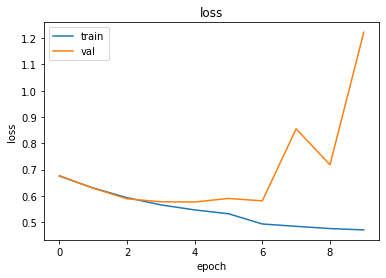

9781
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 24)
pool shape: (None, 3, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 39, 2)     0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 20, 24)    960         zero_padding2d_1[0][0]   

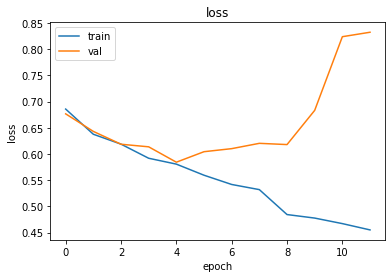

9781
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 24)
pool shape: (None, 3, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 3, 39, 2)     0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 3, 20, 24)    960         zero_padding2d_2[0][0]   

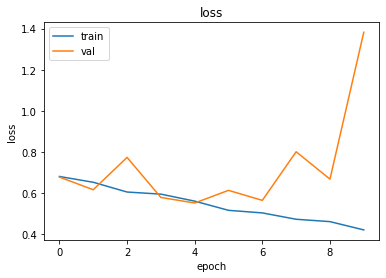

9781
shape after padding: (None, 3, 39, 2)
conv shape: (None, 3, 20, 24)
pool shape: (None, 3, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 3, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 3, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 3, 39, 2)     0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 20, 24)    960         zero_padding2d_3[0][0]   

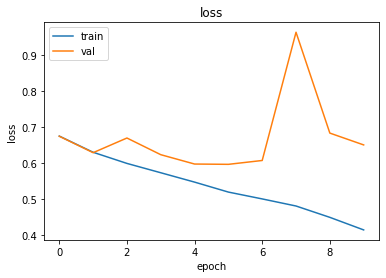

9780
avg_AUC :  0.7772358719987336
avg_AUC_2 :  0.7772226367643604


In [55]:

#@title Default title text
print("\n ======= Select columns for LSTM ALL OBS.=========")

result = []

# First choose all varaibles
#cols = v_perf + v_1+ v_2 + selected_new_all #must order like this
w = 3
perf_cols = v_perf + v_1
words_cols = selected_new_all_sorted
label = 'label'
h = cross_val( df_fl, 'label', \
          perf_cols,\
          words_cols, \
          'cnn_lstm',w, \
          filters = 64)
    
best_auc = h[0]

# Next, remove one from the list each time



In [ ]:
#best_auc

0.752735165519567

In [ ]:

#all_cols = selected_new_all

# selected_cols = selected_new_all + v_1 + v_2
# random.shuffle(selected_cols)

# for col in selected_cols:
    
#     print("\n ===========Test {}============\n".format(col))
    
#     test_cols = [item for item in selected_cols if item !=col]
#     #test_cols = v_perf + v_1+ v_2 + [col]
    
#     # n1 = 2*len(test_cols)
#     # n2 = len(test_cols)
#     label = 'label'
#     h = cross_val( df_fl, label, test_cols + v_perf, 'lstm_wds', 2)

#     gap = h[0] - best_auc
#     print('****** gap: {0:.4f}'.format(gap))
    
#     result.append([col, h[0], best_auc, gap]) #gap
    
#     if h[0]>= best_auc:  # better to drop col
        
#         selected_cols = test_cols
        
#         best_auc = h[0]
        
#         print("*** {} removed ***".format(col))
    
#     print("current auc: {0:.4f}\tbest_auc: {1:.4f}\tcolumn: {2}".format(h[0], best_auc, col))
#     print("selected columns: ", selected_cols)


# pd.DataFrame(result, columns = ["column", "auc", "prev_auc","gap"]).to_csv("var_selection_lstm_bi_2.csv")   

In [ ]:
print(random.shuffle(selected_new_all))

In [ ]:
'Litigious_3_dis' in list(df_fl.columns)

True